<a href="https://colab.research.google.com/github/alracey/level4-project/blob/Higher-dimensions/piecewise_linear_pytorch_2d_opt_bins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#get Times New Roman
import matplotlib.font_manager as fm

!wget -O TimesNewRoman.ttf https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf
font_dirs = ["/content/"]
font_files = fm.findSystemFonts(fontpaths=font_dirs, fontext='ttf')
for font_file in font_files:
    print(font_file) if 'TimesNewRoman' in font_file else None
    fm.fontManager.addfont(font_file)

plt.rcParams['font.serif'] = "Times New Roman"
plt.rcParams['font.family'] = "serif"

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

torch.__version__

--2026-02-08 16:55:00--  https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf [following]
--2026-02-08 16:55:00--  https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 834452 (815K) [application/octet-stream]
Saving to: ‘TimesNewRoman.ttf’

TimesNewRoman.ttf   100%[===================>] 814.89K  --.-KB/s    in 0.05s   

2026-02-08 16:55:00 (17.1 MB/s) - ‘TimesNewRoman.ttf’ saved [834452/834452]

/content/

'2.9.0+cpu'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
dtype = torch.float32

Using device: cpu


This section defines the target function f, the piecewise transform g, and the transformed function h.

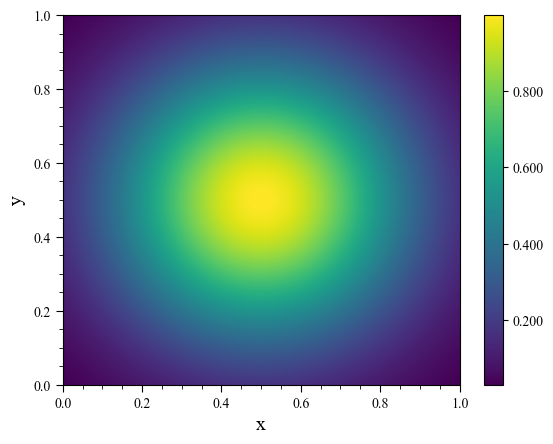

In [76]:
def f(x, y):
  return torch.exp(-7*((x-0.5)**2 + (y-0.5)**2))

def plot_f(N):
  xs, ys = torch.linspace(0, 1, N), torch.linspace(0, 1, N)
  X, Y = torch.meshgrid(xs, ys, indexing='ij')
  Z = f(X, Y)

  fig, ax = plt.subplots()

  pcm = plt.pcolormesh(X, Y, Z, cmap='viridis', shading='auto')

  ax.set_xlabel("$x$", fontsize=14)
  ax.set_ylabel("$y$", fontsize=14)

  ax.tick_params(axis="both", which="major", direction="out", length=5, labelsize=10)
  ax.tick_params(axis="both", which="minor", direction="out", length=3)
  ax.minorticks_on()

  cbar = plt.colorbar(pcm, ax=ax)
  cbar.formatter = ticker.FormatStrFormatter('%.3f')
  cbar.update_ticks()

  ax.set_xlim(0.0, 1.0)
  ax.set_ylim(0.0, 1.0)

  plt.show()
  return fig

test = plot_f(1000)

In [4]:
### example parameters ###
D, n, K = 2, 10, 8

In [5]:
def g(x, params, bins):

  '''
  Piecewise-linear transform with K bins, independent in different dimensions.
  bins: tensor of bin edges including zero and one.  Shape (D, K+1)
  x.shape = (D, n); params.shape = (D, K-1) where D is dimensions, K is number of bins, n is variable
  "x ---> y"
  '''

  device = x.device
  dtype = x.dtype

  D, n = x.shape
  K = params.size(1) + 1

  #cdf heights
  zeros = torch.zeros((params.size(0), 1), device=device, dtype=dtype)
  ones = torch.ones((params.size(0), 1), device=device, dtype=dtype)
  heights = torch.cat([zeros, params, ones], dim=1)

  #find indices
  i_values = []
  for d in range(D):
    i_d = torch.bucketize(x[d], bins[d], right=False) - 1
    i_values.append(i_d)

  i_values = torch.stack(i_values, dim=0)
  i_values_right = torch.clamp(i_values + 1, max=K)

  # Create row indices as not working in 1D
  row_indices = torch.arange(D, device=device).unsqueeze(1)

  #compute the edges
  x_left = bins[row_indices, i_values]
  x_right = bins[row_indices, i_values_right]
  y_left = heights[row_indices, i_values]
  y_right = heights[row_indices, i_values_right]

  #compute the linear mappings for all x

  y = y_left + ((y_right - y_left) / (x_right - x_left)) * (x - x_left)

  return y


In [6]:
def plot_g(params, bins, dim, display_bins):
  '''
  dimension = 0 or 1
  '''

  x_plot = torch.rand(D, 1000)
  x_plot = x_plot.sort(dim=1).values

  g_plot = g(x_plot, params, bins)

  fig, ax = plt.subplots()

  ax.plot(x_plot[dim].cpu(), g_plot[dim].cpu())

  if display_bins == True:
    for b in bins[dim][1:-1]:
      ax.axvline(b.item(), color="gray", alpha=0.6)

  ax.set_xlabel(f"$x_{dim+1}$", fontsize=14)
  ax.set_ylabel(f"$g(x_{dim+1})$", fontsize=14)

  ax.set_xlim(0.0, 1.0)
  ax.set_ylim(0.0, 1.0)

  ax.tick_params(axis="both", which="major", direction="in", length=5, labelsize=10)
  ax.tick_params(axis="both", which="minor", direction="in", length=3)
  ax.minorticks_on()

  plt.show()

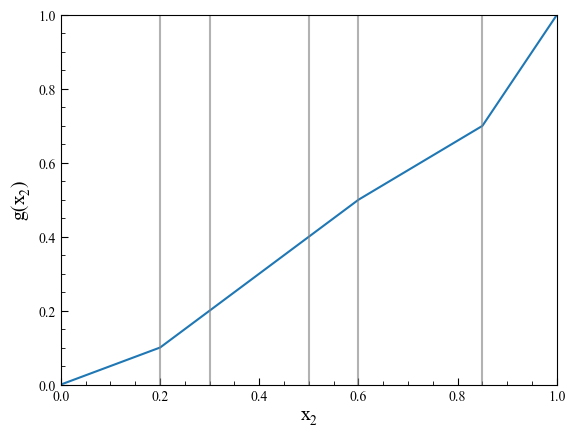

In [7]:
#testing

test_params = torch.tensor([[0.2, 0.3, 0.5, 0.7, 0.8],
                      [0.1, 0.2, 0.4, 0.5, 0.7]], device='cpu')

test_bins = torch.tensor([0, 0.2, 0.3, 0.5, 0.6, 0.85, 1]).repeat(D, 1)

plot_g(test_params, test_bins, dim=1, display_bins=True)


In [ ]:
#debugging

'''
It seems like for random x input tensors, clamping between 0 and K is not needed.
And if the input x includes zero and one, for example in a linspace, the indices are not correct even with clamping.
'''

K=9
x_linspace = torch.linspace(0, 1, 20).repeat(D, 1)
x_rand = torch.rand(D, 20)
print('linear x:', x_linspace[0])
print('random x:', x_rand[0])
bins = torch.linspace(0, 1, K+1).repeat(D, 1)
print('bins: ', bins[0])
i_l = torch.bucketize(x_linspace[0], bins[0], right=False) - 1
print('linspace indices:', i_l)
i_r = torch.bucketize(x_rand[0], bins[0], right=False) - 1
print('random indices:', i_r)


linear x: tensor([0.0000, 0.0526, 0.1053, 0.1579, 0.2105, 0.2632, 0.3158, 0.3684, 0.4211,
        0.4737, 0.5263, 0.5789, 0.6316, 0.6842, 0.7368, 0.7895, 0.8421, 0.8947,
        0.9474, 1.0000])
random x: tensor([0.6053, 0.7411, 0.9990, 0.2103, 0.0308, 0.8584, 0.6371, 0.0705, 0.4734,
        0.2223, 0.0494, 0.2609, 0.2131, 0.1323, 0.7797, 0.2976, 0.1672, 0.5766,
        0.0491, 0.1979])
bins:  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])
linspace indices: tensor([-1,  0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,
         8,  8])
random indices: tensor([5, 6, 8, 1, 0, 7, 5, 0, 4, 2, 0, 2, 1, 1, 7, 2, 1, 5, 0, 1])


In [8]:
def h(y, params, bins):

  '''
  Resulting function when the piecewise warp is applied, in accordance with the change of variables formula.
  Integral should be preserved.
  Non-uniform bins permitted.
  '''

  device = y.device
  dtype = y.dtype

  D, n = y.shape
  K = params.size(1) + 1

  #cdf heights
  zeros = torch.zeros((params.size(0), 1), device=device, dtype=dtype)
  ones = torch.ones((params.size(0), 1), device=device, dtype=dtype)
  heights = torch.cat([zeros, params, ones], dim=1)

  #find indices
  j_values = []
  for d in range(D):
    j_d = torch.bucketize(y[d], heights[d], right=False) - 1
    j_values.append(j_d)

  j_values = torch.stack(j_values, dim=0)
  j_values_right = torch.clamp(j_values + 1, max=K)

  # Create row indices
  row_indices = torch.arange(D, device=device).unsqueeze(1)

  #compute the edges
  x_left = bins[row_indices, j_values]
  x_right = bins[row_indices, j_values_right]
  y_left = heights[row_indices, j_values]
  y_right = heights[row_indices, j_values_right]

  def g_inv(y):

    return x_left + ((x_right - x_left) / (y_right - y_left)) * (y - y_left)

  jacobians = (x_right - x_left) / (y_right - y_left)

  arg = g_inv(y)
  jac_det = jacobians.prod(dim=0)

  return f(*arg) * jac_det

In [9]:
#functions to plot h

def h_plot(params, bins, N, levels):

  '''
  NB requires matplotlib.ticker to have been imported
  '''

  ys = torch.rand(N)
  ys = torch.sort(ys).values
  Y1, Y2 = torch.meshgrid(ys, ys, indexing='ij')
  points = torch.stack([Y1.flatten(), Y2.flatten()], dim=0)

  h_eval = h(points, params, bins)

  Z = h_eval.view(N, N).cpu()

  fig, ax = plt.subplots(figsize=(8,6))

  contour_plot = ax.contour(Y1.cpu(), Y2.cpu(), Z, levels=levels, cmap='viridis')

  ax.set_xlabel("$y_1$", fontsize=16)
  ax.set_ylabel("$y_2$", fontsize=16)

  ax.tick_params(axis="both", which="major", direction="out", length=5, labelsize=10)
  ax.tick_params(axis="both", which="minor", direction="out", length=3)
  ax.minorticks_on()

  ##legend decimal places##
  cbar = plt.colorbar(contour_plot, ax=ax)
  cbar.formatter = ticker.FormatStrFormatter('%.3f')
  cbar.update_ticks()

  ax.set_xlim(0.0, 1.0)
  ax.set_ylim(0.0, 1.0)

  plt.show()


def h_plot_colormesh(params, bins, N, shading):

  ys = torch.rand(N)
  ys = torch.sort(ys).values
  Y1, Y2 = torch.meshgrid(ys, ys, indexing='ij')
  points = torch.stack([Y1.flatten(), Y2.flatten()], dim=0)

  h_eval = h(points, params, bins)

  Z = h_eval.view(N, N).cpu()

  fig, ax = plt.subplots(figsize=(8,6))

  pcm = plt.pcolormesh(
    Y1,
    Y2,
    Z,
    cmap='viridis',
    shading='auto'
  )

  ax.set_xlabel("$y_1$", fontsize=14)
  ax.set_ylabel("$y_2$", fontsize=14)

  ax.tick_params(axis="both", which="major", direction="out", length=5, labelsize=10)
  ax.tick_params(axis="both", which="minor", direction="out", length=3)
  ax.minorticks_on()

  cbar = plt.colorbar(pcm, ax=ax)
  cbar.formatter = ticker.FormatStrFormatter('%.3f')
  cbar.update_ticks()

  ax.set_xlim(0.0, 1.0)
  ax.set_ylim(0.0, 1.0)

  plt.show()

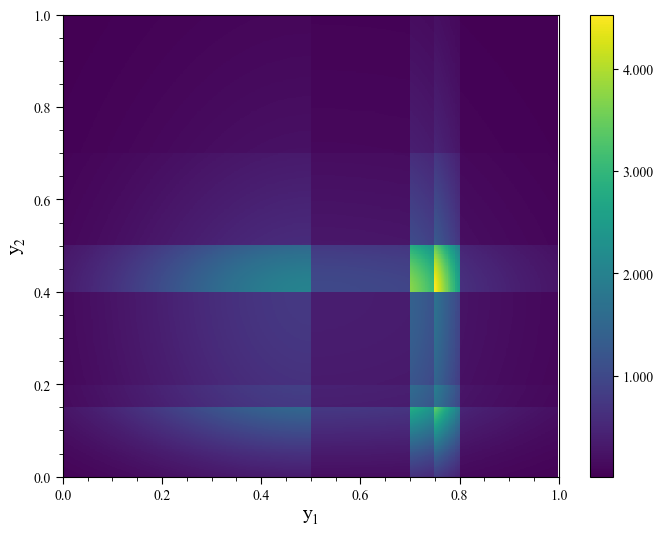

In [56]:
#testing

test_params = torch.tensor([[0.2, 0.3, 0.35, 0.5, 0.7, 0.75, 0.8],
                      [0.1, 0.15, 0.2, 0.4, 0.45, 0.5, 0.7]], device='cpu')

test_bins = torch.tensor([0, 0.2, 0.3, 0.35, 0.5, 0.6, 0.7, 0.85, 1]).repeat(D, 1)

h_plot_colormesh(test_params, test_bins, N=1000, shading='auto')

This section checks that the integral of the function is preserved under the transformation, and checks that the variances are sensible.

In [77]:
test_params = torch.tensor([[0.1, 0.2, 0.35, 0.4, 0.5, 0.7, 0.8],
                            [0.2, 0.3, 0.5, 0.6, 0.8, 0.85, 0.9]])

test_bins = torch.tensor([0, 0.2, 0.3, 0.35, 0.5, 0.6, 0.7, 0.85, 1]).repeat(D, 1)

N = 1000000

#reference value: 0.395405

def MC_F(N):
  x, y = torch.rand(N), torch.rand(N)
  f_evals = f(x, y)
  F_est = torch.mean(f_evals)
  alpha_F = torch.std(f_evals) / torch.sqrt(torch.tensor(N))
  return F_est, alpha_F

def MC_H(N, params, bins):
  ys = torch.rand(D, N)
  h_evals = h(ys, params, bins)
  H_est = torch.mean(h_evals)
  alpha_H = torch.std(h_evals) / torch.sqrt(torch.tensor(N))
  return H_est, alpha_H


F_est, alpha_F = MC_F(N)
print(f'F estimate = {F_est} ± {alpha_F}')

H_est, alpha_H = MC_H(N, test_params, test_bins)
print(f'H estimate = {H_est} ± {alpha_H}')


#can histogram results if needed

F estimate = 0.3952978551387787 ± 0.00025372151867486537
H estimate = 0.39514774084091187 ± 0.0005652311374433339


In [78]:
#check that variances are different in general
x_test, y_test = torch.rand(N), torch.rand(N)
y = torch.stack((x_test, y_test), dim=0)

f_var = torch.var(f(x_test, y_test))

h_for_var = h(y, test_params, test_bins)
h_var = torch.var(h_for_var)

print("F variance:", f_var)
print("H variance:", h_var)

F variance: tensor(0.0644)
H variance: tensor(0.3204)


This section adds the use of unconstrained parameters by defining a softmax function to make varying K easier.  The training loop for minimising the variance is defined and a test plot of h is made for some optimised parameters.

In [20]:
#unconstrained parameters (makes varying K easier)

example_params = torch.zeros(2, 7)
example_raw_widths = torch.rand(2, 8)

import torch.nn.functional
def u_to_y(u):

  device = u.device
  dtype = u.dtype

  zeros = torch.zeros((u.size(0), 1), device=device, dtype=dtype)
  u_ext = torch.cat([u, zeros], dim=1)
  w = torch.nn.functional.softmax(u_ext, dim=1)
  ys = torch.cumsum(w, dim=1)
  return ys[:, :-1]

#print(u_to_y(example_params))

def softmax(widths):
  return torch.nn.functional.softmax(widths, dim=1)

#print(softmax(example_raw_widths))

def widths_to_edges(widths):    #assumes widths sum to 1

  int_edges = torch.cumsum(widths, dim=1)
  edges = torch.cat([int_edges.new_zeros((D, 1)), int_edges], dim=1)
  return edges

#widths = softmax(example_raw_widths)
#print(widths)
#edges = widths_to_edges(widths)
#print(edges)

In [32]:
#optimisation

#can use a training loop, variance is the loss function

def train_loop_improved(x, K, epochs, lr, device, ticker):
  '''
  x.shape = (D, n); K bins, D dimensions
  '''

  if device is None:
    device = x.device

  x = x.to(device=device, dtype=dtype)    #float64 precision can be added here
  D = x.size(0)

  #cdf heights
  raw_heights = torch.zeros((D, K-1), device=device, dtype=dtype, requires_grad=True)

  #bin widths
  raw_widths = torch.rand((D, K), device=device, dtype=dtype, requires_grad=True)

  #optimiser
  optimiser = torch.optim.Adam([
      {"params": raw_heights, "lr": lr},
      {"params": raw_widths, "lr": lr * 0.25}   #decoupled learning rates
      ])


  loss_values = torch.zeros(epochs, device=device)

  for epoch in range(epochs):

    heights = u_to_y(raw_heights)
    widths = softmax(raw_widths)
    bins = widths_to_edges(widths)

    g_eval = g(x, heights, bins)
    h_eval = h(g_eval, heights, bins)

    loss = torch.var(h_eval)
    loss_values[epoch] = loss.detach()

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

    if ticker and epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.8e}")

    final_loss = loss.detach()
    final_params = u_to_y(raw_heights).detach()
    final_widths = softmax(raw_widths).detach()

  return final_loss, loss_values, final_params, final_widths


In [82]:
train_x = torch.rand(2, 1000)
final_loss, loss_values, opt_params, opt_widths = train_loop_improved(train_x, K=32, epochs=250, lr=0.05, device=device, ticker=True)

opt_bins = widths_to_edges(opt_widths)

print("Final loss:", final_loss.item())
print("Optimised parameters:", opt_params)
print("Optimised bin edges:", opt_bins)

Epoch: 0 | Loss: 1.74480841e-01
Epoch: 10 | Loss: 1.96021441e-02
Epoch: 20 | Loss: 1.16585931e-02
Epoch: 30 | Loss: 6.30849646e-03
Epoch: 40 | Loss: 5.06747374e-03
Epoch: 50 | Loss: 3.68659222e-03
Epoch: 60 | Loss: 2.75895884e-03
Epoch: 70 | Loss: 1.94698875e-03
Epoch: 80 | Loss: 1.26782840e-03
Epoch: 90 | Loss: 9.80090233e-04
Epoch: 100 | Loss: 9.30853945e-04
Epoch: 110 | Loss: 9.88373766e-04
Epoch: 120 | Loss: 9.46180488e-04
Epoch: 130 | Loss: 9.24460939e-04
Epoch: 140 | Loss: 9.18179343e-04
Epoch: 150 | Loss: 9.24453896e-04
Epoch: 160 | Loss: 9.21792467e-04
Epoch: 170 | Loss: 9.50412825e-04
Epoch: 180 | Loss: 9.33280622e-04
Epoch: 190 | Loss: 9.41637787e-04
Epoch: 200 | Loss: 9.56738251e-04
Epoch: 210 | Loss: 9.74396535e-04
Epoch: 220 | Loss: 9.66454681e-04
Epoch: 230 | Loss: 9.77091840e-04
Epoch: 240 | Loss: 9.80754383e-04
Final loss: 0.0009907251223921776
Optimised parameters: tensor([[0.0133, 0.0294, 0.0535, 0.0777, 0.1105, 0.1367, 0.1645, 0.1971, 0.2276,
         0.2605, 0.2986,

Optimised parameters: tensor([[0.0133, 0.0294, 0.0535, 0.0777, 0.1105, 0.1367, 0.1645, 0.1971, 0.2276,
         0.2605, 0.2986, 0.3258, 0.3805, 0.4341, 0.4858, 0.5397, 0.5666, 0.5957,
         0.6502, 0.6977, 0.7463, 0.7766, 0.8065, 0.8314, 0.8564, 0.8799, 0.9077,
         0.9250, 0.9395, 0.9571, 0.9691],
        [0.0138, 0.0359, 0.0538, 0.0788, 0.1016, 0.1280, 0.1495, 0.1936, 0.2234,
         0.2476, 0.2780, 0.3109, 0.3376, 0.3635, 0.4061, 0.4329, 0.4794, 0.5032,
         0.5510, 0.6089, 0.6694, 0.7001, 0.7469, 0.7868, 0.8172, 0.8616, 0.8877,
         0.9106, 0.9304, 0.9556, 0.9694]])
Optimised bin edges: tensor([[0.0000, 0.0409, 0.0795, 0.1248, 0.1618, 0.2033, 0.2329, 0.2603, 0.2893,
         0.3150, 0.3410, 0.3687, 0.3876, 0.4242, 0.4596, 0.4917, 0.5258, 0.5429,
         0.5617, 0.5971, 0.6298, 0.6655, 0.6894, 0.7146, 0.7367, 0.7609, 0.7856,
         0.8189, 0.8422, 0.8643, 0.8943, 0.9187, 1.0000],
        [0.0000, 0.0433, 0.0936, 0.1265, 0.1647, 0.1942, 0.2245, 0.2466, 0.2866,
    

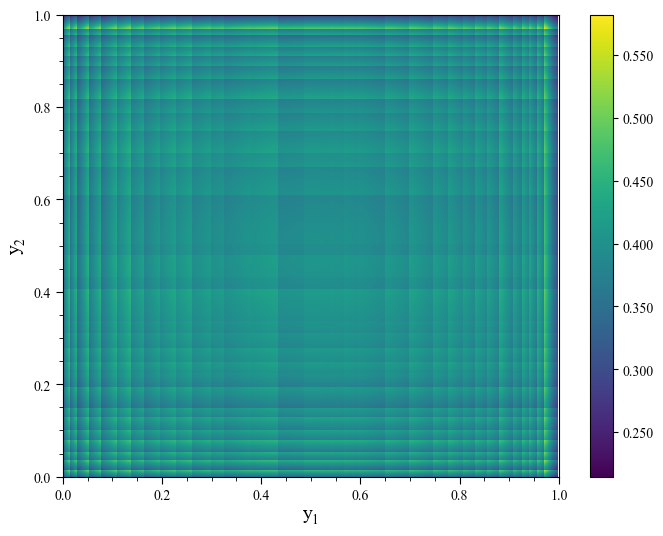

In [83]:
print("Optimised parameters:", opt_params)
print("Optimised bin edges:", opt_bins)

h_plot_colormesh(opt_params, opt_bins, N=2500, shading='auto')

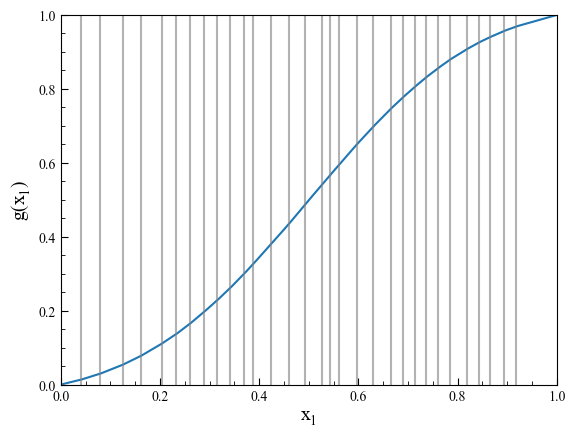

In [86]:
#plot the transform function g with optimal parameters

plot_g(opt_params, opt_bins, dim=0, display_bins=True)

This section is purely for visualisation/analysis tools - variation of loss with epoch, final loss vs number of bins, loss vs epoch for different learning rates, histogram of function evaluations for variance estimates.
NB the below plots have not been run on the steeper exponential defined at the beginning yet; they are for the original Gaussian.

Loss vs epoch for different K

In [47]:
#generate data

device = x_test.device
dtype = x_test.dtype

K_s = [2, 4, 8, 16, 32, 64, 128]
epochs = 200
loss_values = torch.zeros((len(K_s), epochs), device=device, dtype=dtype)

results = {}  # K -> loss tensor

for K in K_s:
    _, losses, _, _ = train_loop_improved(
        train_x,
        K,
        epochs,
        lr=0.05,
        device=device,
        ticker=False,
    )
    results[K] = losses.detach().cpu()

/tmp/ipython-input-3279338674.py:19: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


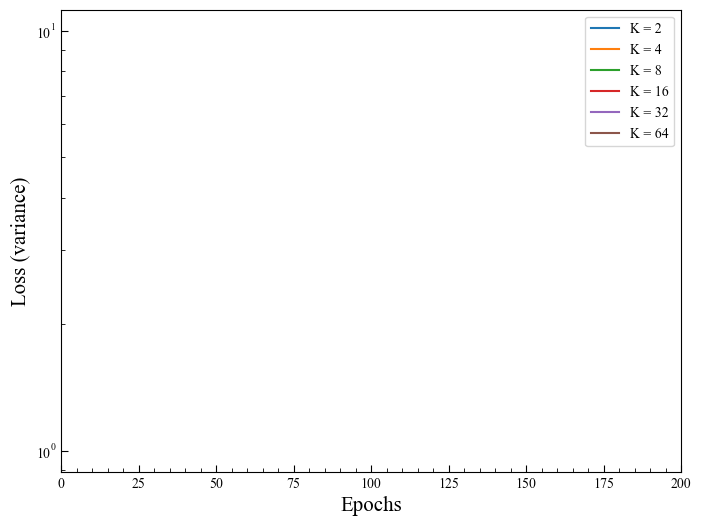

In [45]:
#plotting if not using the dict (early stopping friendly) format

fig, ax = plt.subplots(figsize=(8,6))

epochs_plot = torch.arange(epochs)
for i in range(len(K_s)):
  ax.plot(epochs_plot, loss_values[i].detach().numpy(), label=f'K = {K_s[i]}')

ax.set_xlabel("Epochs", fontsize=15)
ax.set_ylabel("Loss (variance)", fontsize=15)

ax.tick_params(axis="both", which="major", direction="in", length=5, labelsize=10)
ax.tick_params(axis="both", which="minor", direction="in", length=3)
ax.minorticks_on()

ax.set_xlim(0, 200)

plt.legend()
plt.yscale('log')
plt.show()

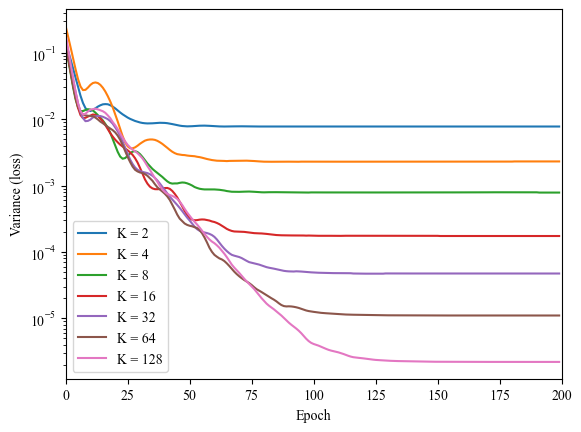

In [48]:
#plotting for early stopping enabled

plt.figure()

for K, losses in results.items():
  epochs_plot = torch.arange(len(losses))
  plt.plot(epochs_plot, losses.numpy(), label=f"K = {K}")

plt.xlabel("Epoch")
plt.ylabel("Variance (loss)")
plt.yscale("log")
plt.xlim(0, 200)
plt.legend()
plt.show()

Loss vs K

In [49]:
#generate data

Ks = range(2, 65)
vars = torch.zeros(len(Ks), device=device)
i=0

for K in Ks:
  result = train_loop_improved(x_test, K, epochs=200, lr=0.05, device=device, ticker=False)[0]
  vars[i] = result.reshape(1) # Reshape scalar to a 1D tensor
  i += 1

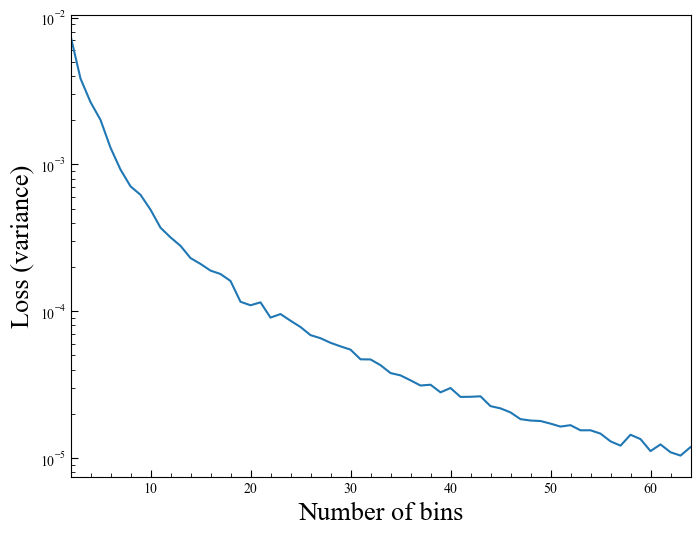

tensor(1.1866e-05)


In [50]:
#plotting

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(Ks, vars.detach().numpy())  # Detach and convert to numpy for plotting

ax.set_xlabel("Number of bins", fontsize=19)
ax.set_ylabel("Loss (variance)", fontsize=19)

ax.tick_params(axis="both", which="major", direction="in", length=5, labelsize=10)
ax.tick_params(axis="both", which="minor", direction="in", length=3)
ax.minorticks_on()

ax.set_xlim(2, 64)
plt.yscale('log')
plt.show()
print(vars[-1])     #check accuracy

Loss vs epoch for different learning rates

In [51]:
#generate data

K = 16
l_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5]
epochs=200
loss_values = torch.zeros((len(l_rates), epochs), device=device)

for i in range(len(l_rates)):
  loss_values[i] = train_loop_improved(x_test, K, epochs, lr=l_rates[i], device=device, ticker=False)[1]

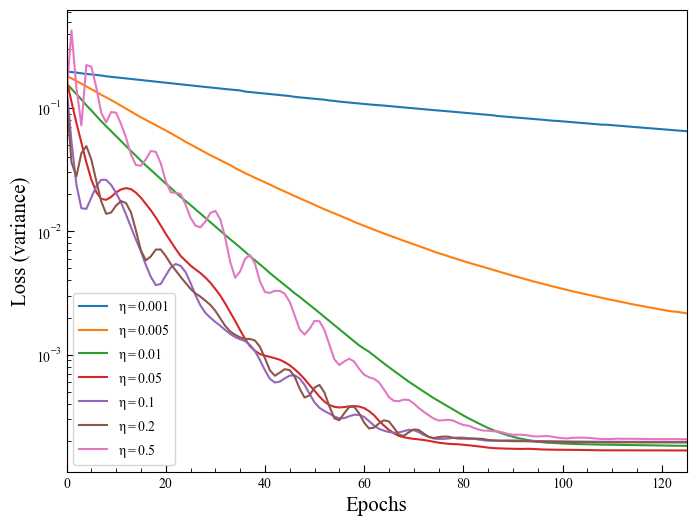

In [53]:
#plotting

fig, ax = plt.subplots(figsize=(8, 6))

epochs_plot = torch.arange(epochs, device='cpu')
for i in range(len(l_rates)):
  ax.plot(epochs_plot, loss_values[i].detach().cpu().numpy(), label=rf"$\eta = {l_rates[i]}$")

ax.set_xlabel("Epochs", fontsize=15)
ax.set_ylabel("Loss (variance)", fontsize=15)

ax.tick_params(axis="both", which="major", direction="in", length=5, labelsize=10)
ax.tick_params(axis="both", which="minor", direction="in", length=3)
ax.minorticks_on()

ax.set_xlim(0, 125)

plt.legend()
plt.yscale('log')
plt.show()